# Aim: Improve filter module so that works both for test06 too (in this case test07)

# Denoising SWOT data with a first order penalization filter 
* L. Gómez Navarro, E. Cosme, J. Le Sommer and A. Monsimer
* Started on 12 August 2017, last update on 23rd November 2017

# (to edit below)

## Objective

This notebook illustrates the implementation of a first order penalization filter provided by N. Papadakis to filter out noise from SWOT data. It applies the filter for a given lambda and number of iterations, and saves the filtered data in a netCDF file. This notebook is adapted for the BOX selected SWOT dataset.

## Input and output data

SWOT data here comes in the form of a NetCDF files from the SWOT ocean simulator. In this case 1km grid resolution BOX selected dataset is used.  It can be downloaded here:

The file can be downloaded here: 

xxxxxxxx

The output is similar, containing the filtered fields.


## Related links

* https://github.com/SWOTsimulator

# Adapted from:
* 2017-07-26_REG_filter_example_NEWODEULEVERSION.ipynb
* 2017-11-23_box_FMA_reading_demo_rough.ipynb

# Filtering Method description 
##### (Image denoising, N. Papadakis, March 2017)

### 1. Tikhonov regularization
We consider a noisy image $h_{obs}$ that we want to restore. We assume that the image $h_{obs}$ corresponds to a clean “ground truth” image $h_0$ that has been perturbed by an additional white Gaussian noise $ε$ so that: $h_{obs} = h_0 + ε$. To do so, one can consider the Tikhonov regularization of the gradient of the image and try to minimize the functional:
<br>
<br>
$$ J(h) = \frac{1}{2} \Vert h - h_{obs} \Vert ^2 + \frac{\lambda}{2} \Vert \nabla h \Vert ^2 $$
<br>
<br>
To optimize this convex problem, a simple gradient descent algorithm can be performed.
We have:
<br>
<br>
$$ \langle \nabla J(h),dh \rangle = \lim_{\epsilon\to0} \frac{J (h + \epsilon dh) - J(h)}{\epsilon} $$


### 2. Adaptation to SSH denoising
Let h denote a SSH map. From geostrophic balance one can assume that $v ∝ ∇^⊥ h$, where $v$ is the surface velocity. In this case, one has $ξ ∝ ∆h$, where $ξ$ is the relative vorticity, that is assumed spatially smooth. In the previous model, by regularizing the gradient of $h$, we are looking for a solution where $||∇h||$ is small, i.e. where the norm of the velocity field is small. This may be a bad regularization model.
Hence, a physically sound model to restore a noisy SSH map $h_{obs}$ could be to regularize the gradient of the vorticity, i.e. the gradients of the laplacian of the image:

<br>
$$ J(h) = \frac{1}{2}||h − h_{obs}||^2  +  \frac{λ}{2}||∇∆h||^2 $$
<br>
This problem can still be solved with a gradient descent algorithm that now reads:

<br>
$$h^{k+1} = h^k + τ(h_{obs} − h^k + λ∆∆∆h^k)$$
<br>
, and $τ$ should be taken as: $τ < 1/(1 + 512λ)$ to ensure the convergence of the algorithm.


# Loading the necesssary modules:

In [1]:
import glob
from netCDF4 import Dataset
import xarray as xr

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap

from shutil import copyfile
import os

%pylab inline

#from scipy import ndimage
from scipy import ndimage as nd

Populating the interactive namespace from numpy and matplotlib


# Defining the necessary functions:

In [2]:
def gradi(I): 
    """
    Calculates the gradient in the x-direction of an image I and gives as output M.
    In order to keep the size of the initial image the last row is left as 0s.
    """
    
    m, n = I.shape
    M = np.zeros([m,n])

    M[0:-1,:] = np.subtract(I[1::,:], I[0:-1,:])
    return M

def gradj(I): 
    """
    Calculates the gradient in the y-direction of an image I and gives as output M.
    In order to keep the size of the initial image the last column is left as 0s.
    """
    
    m, n = I.shape
    M = np.zeros([m,n])
    M[:,0:-1] =  np.subtract(I[:,1::], I[:,0:-1])
    return M


## I:
   T$_{0,0}$    T$_{0,1}$    T$_{0,2}$    T$_{0,3}$    T$_{0,4}$    T$_{0,5}$ 
   <br>
   <br>
   T$_{1,0}$    T$_{1,1}$    T$_{1,2}$    T$_{1,3}$    T$_{1,4}$    T$_{1,5}$
   <br>
   <br>
   T$_{2,0}$    T$_{2,1}$    T$_{1,2}$    T$_{1,3}$    T$_{1,4}$    T$_{1,5}$
   <br>
   <br>
   T$_{3,0}$    T$_{3,1}$    T$_{1,2}$    T$_{1,3}$    T$_{1,4}$    T$_{1,5}$
   <br>
   <br>
   T$_{4,0}$    T$_{4,1}$    T$_{1,2}$    T$_{1,3}$    T$_{1,4}$    T$_{1,5}$
   <br>
   <br>
   T$_{5,0}$    T$_{5,1}$    T$_{1,2}$    T$_{1,3}$    T$_{1,4}$    T$_{1,5}$


## gradi(I):
   T$_{1,0}$ - T$_{0,0}$ &nbsp;&nbsp;&nbsp;    T$_{0,1}$    T$_{0,2}$    T$_{0,3}$    T$_{0,4}$    T$_{0,5}$ 
   <br>
   <br>
   T$_{2,1}$ - T$_{1,1}$ &nbsp;&nbsp;&nbsp;    T$_{2,1}$ - T$_{1,1}$ &nbsp;&nbsp;&nbsp;    T$_{2,2}$ - T$_{1,2}$&nbsp;&nbsp;&nbsp;         T$_{2,3}$ - T$_{1,3}$ &nbsp;&nbsp;&nbsp;    T$_{2,4}$ - T$_{1,4}$ &nbsp;&nbsp;&nbsp;   T$_{2,5}$ - T$_{1,5}$ &nbsp;&nbsp;&nbsp;
   <br>
   <br>
   T$_{2,1}$ - T$_{1,1}$ &nbsp;&nbsp;&nbsp;    T$_{3,1}$ - T$_{2,1}$    T$_{2,2}$    T$_{2,3}$    T$_{2,4}$    T$_{2,5}$
   <br>
   <br>
   T$_{2,1}$ - T$_{1,1}$ &nbsp;&nbsp;&nbsp;    T$_{3,1}$    T$_{3,2}$    T$_{1,3}$    T$_{1,4}$    T$_{1,5}$
   <br>
   <br>
   T$_{2,1}$ - T$_{1,1}$ &nbsp;&nbsp;&nbsp;    T$_{4,1}$    T$_{1,2}$    T$_{1,3}$    T$_{1,4}$    T$_{1,5}$
   <br>
   <br>
   0            0            0            0            0


## gradj(I):   
   T$_{1,2}$ - T$_{1,1}$ &nbsp;&nbsp;&nbsp;    T$_{1,2}$    T$_{1,3}$    T$_{1,4}$    0
   <br>
   <br>
   T$_{2,1}$    T$_{1,2}$    T$_{1,3}$    T$_{1,4}$    0
   <br>
   <br>
   T$_{3,1}$    T$_{1,2}$    T$_{1,3}$    T$_{1,4}$    0
   <br>
   <br>
   T$_{4,1}$    T$_{1,2}$    T$_{1,3}$    T$_{1,4}$    0
   <br>
   <br>
   T$_{5,1}$    T$_{1,2}$    T$_{1,3}$    T$_{1,4}$    0

In [29]:
def div(px, py): 
    """
    Calculates the divergence of a vector (px, py) and gives M as ouput
    ; where px and py have the some size and are the gradient in x and y respectively 
    of a variable p.
    The x component of M (Mx) first row is = to the first row of px.
    The x component of M (Mx) last row is = to - the before last row of px. (last one = 0)
    The y component of M (My) first column is = to the first column of py.
    The y component of M (My) last column is = to - the before last column of py. (last one = 0)
    ??#(de sorte que div=-(grad)^*)
    """
    m, n = px.shape
    M = np.zeros([m,n])
    Mx = np.zeros([m,n])
    My = np.zeros([m,n])
 
    Mx[1:m-1, :] = px[1:m-1, :] - px[0:m-2, :]
    Mx[0, :] = px[0, :]
    Mx[m-1, :] = -px[m-2, :]

    My[:, 1:n-1] = py[:, 1:n-1] - py[:, 0:n-2]
    My[:, 0] = py[:,0]
    My[:, n-1] = -py[:, n-2]
     
    M = Mx + My;
    return M

def np_laplacian(u):
    """
    Calculates the laplacian of u using the divergence and gradient functions and gives 
    as output Ml.
    """
    Ml = div(gradi(u), gradj(u));
    return Ml

def trilaplacian(u):
    u2 = laplacian(laplacian(laplacian(u)))
    
    return u2

## div(Ii, I):
   T$_{2,1}$ - T$_{1,1}$ &nbsp;&nbsp;&nbsp;    T$_{2,2}$ - T$_{1,2}$&nbsp;&nbsp;&nbsp;         T$_{2,3}$ - T$_{1,3}$ &nbsp;&nbsp;&nbsp;    T$_{2,4}$ - T$_{1,4}$ &nbsp;&nbsp;&nbsp;   T$_{2,5}$ - T$_{1,5}$ &nbsp;&nbsp;&nbsp;
   <br>
   <br>
   T$_{3,1}$ - T$_{2,1}$    T$_{2,2}$    T$_{2,3}$    T$_{2,4}$    T$_{2,5}$
   <br>
   <br>
   T$_{3,1}$    T$_{3,2}$    T$_{1,3}$    T$_{1,4}$    T$_{1,5}$
   <br>
   <br>
   T$_{4,1}$    T$_{1,2}$    T$_{1,3}$    T$_{1,4}$    T$_{1,5}$
   <br>
   <br>
   0            0            0            0            0


In [4]:
def gaussian_with_nans(u, sigma):
    '''
    Evan Mason
    http://stackoverflow.com/questions/18697532/gaussian-filtering-a-image-with-nan-in-python
    '''
    assert np.ma.any(u.mask), 'u must be a masked array'
    mask = np.flatnonzero(u.mask)
    #u.flat[mask] = np.nan

    v = u.data.copy()
    #v.flat[mask] = 0
    v[:] = nd.gaussian_filter(v ,sigma=sigma)

    w = np.ones_like(u.data)
    w.flat[mask] = 0
    w[:] = nd.gaussian_filter(w, sigma=sigma)

    return v/w

In [5]:
sys.path.insert(0, "/Users/laura/PhD_private/develop/SWOT/")
import SWOT_data_class

# Loading test 7:

In [6]:
_datadir = '/Users/laura/PhD_private/data/SWOT_box_selections/'
_namdescr = '/Users/laura/src/git/swotsimulator/swotoutput/FASTtest07/' + 'swot_simulator.output'
_namfiles_simu = 'MED_1km_nogap_FMA13_swotFastPhase_BOX_'

In [7]:
swot_pass_t7_b = SWOT_data_class.swot_pass(_datadir, _namfiles_simu, _namdescr)

In [8]:
swotfiles = swot_pass_t7_b.get_list_of_swotfiles()

In [9]:
print swotfiles[0]
swot_pass_t7_b.read_data_ncfile_box(swotfiles[0])

/Users/laura/PhD_private/data/SWOT_box_selections/MED_1km_nogap_FMA13_swotFastPhase_BOX_c01_p009.nc


In [10]:
swot_pass_t7_b.box = [2., 5., 37., 40.]

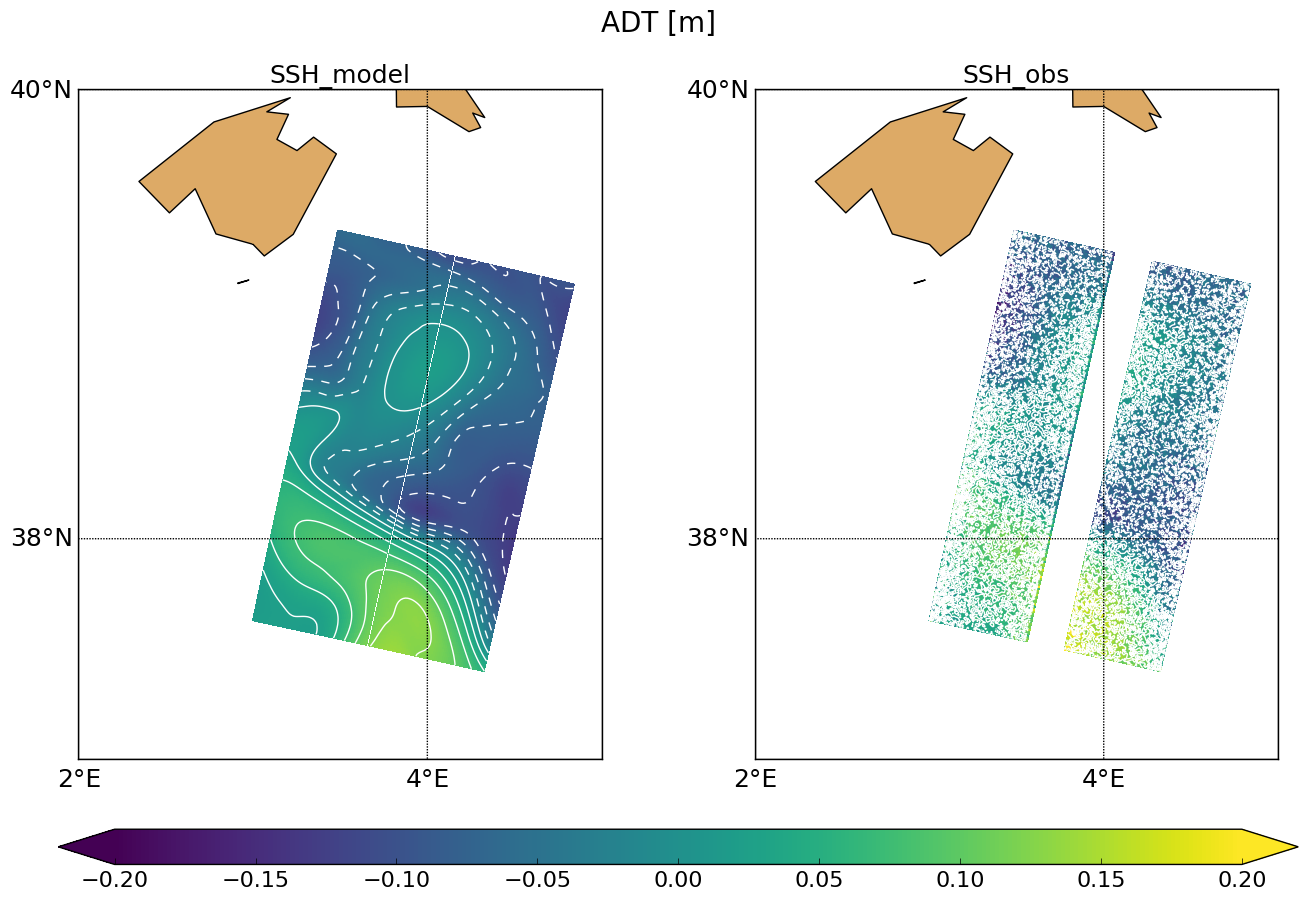

In [11]:
vmin = -.2
vmax = +.2
plt.figure(figsize = (16, 10))

ax1, ax2 = swot_pass_t7_b.plot_model_vs_obs(swot_pass_t7_b.SSH_model, swot_pass_t7_b.SSH_obs, vmin, vmax
                , cmap='viridis', extend_opt = 'both', land=1, plotstyle='1', levels=np.arange(vmin, vmax, .025))

ax1.set_title('SSH_model', size=18)
ax2.set_title('SSH_obs', size=18)
plt.suptitle('ADT [m]', size=20)
plt.show()

In [12]:
swot_pass_t7_b.SSH_model.dtype

dtype('float32')

In [13]:
swot_pass_t7_b.SSH_obs.dtype

dtype('float32')

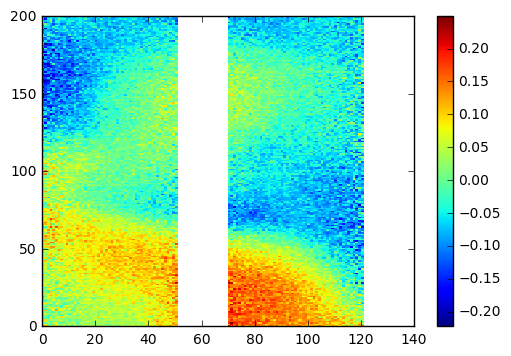

In [14]:
plt.pcolor(swot_pass_t7_b.SSH_obs.T);plt.colorbar()

In [15]:
swot_pass_t7_b.SSH_obs.fill_value

9.96921e+36

In [16]:
#swot_pass_t7_b.SSH_obs? # --> masked array

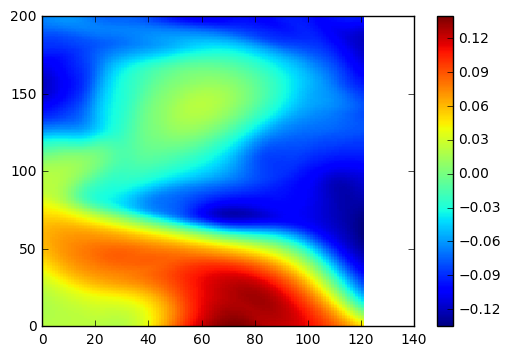

In [17]:
plt.pcolor(swot_pass_t7_b.SSH_model.T);plt.colorbar()

# --> can see a bit some lines, interpolation noise already present in SSH?

# Now using the penalization_filter module to read and filter the data:

swot_pass_t7_b.SSH_model? # NDARRAY
<br>
--> need to mask SSH_model

In [18]:
##=================Preparing the SWOT data arrays===============

# 1. Making SWOT array organized as (lon, lat) a.k.a., (x, y): 
## Not sure how to check this: --> for now ok, boxes saves as x, yso no need for this step
"""
lon = np.transpose(lon)
lat = np.transpose(lat)
SSH_model = np.transpose(SSH_model)
SSH_obs = np.transpose(SSH_obs)
"""

# 2. Check longitude in -180 : +180 format:
#if any abs(longitude) value greater than 180:
#    lon[lon > 180] -= 360 

# 3. Flipping the SWOT array if necessary: 
# So that lon increases from left to right and lat from bottom to top 
# (depends on if pass is ascending or descending)

lon_dif = swot_pass_t7_b.lon[0,1] - swot_pass_t7_b.lon[0,0]
lat_dif = swot_pass_t7_b.lat[1,0] - swot_pass_t7_b.lat[0,0]

if (lat_dif<0):
    print 'flipped variables created'
    ## Ascending pass (pass 22 for in the fast-sampling phase)        
    lon = np.flipud(swot_pass_t7_b.lon)
    lat = np.flipud(swot_pass_t7_b.lat)
    SSH_model = np.flipud(swot_pass_t7_b.SSH_model)
    SSH_obs = np.flipud(swot_pass_t7_b.SSH_obs)

elif (lon_dif<0):
    print 'flipped variables created'
    ## Descending pass (pass 9 for in the fast-sampling phase)
    lon = np.fliplr(swot_pass_t7_b.lon)
    lat = np.fliplr(swot_pass_t7_b.lat)
    SSH_model = np.fliplr(swot_pass_t7_b.SSH_model)
    SSH_obs = np.fliplr(swot_pass_t7_b.SSH_obs)

    
# 3. Fixing the SWOT grid (regular longitude increments, i.e., no jump in swath gap or repeated nadir values)
# At a 1km resolution, should have a size of 121 across track (size of first dim after transposing)    

xx, yy = swot_pass_t7_b.lon.shape
if (swot_pass_t7_b.lon[(xx/2)-1, 0] == swot_pass_t7_b.lon [xx/2, 0]): # this only happens
# when simulation is done with no gap
    print '_nogap variables created'
    # if no gap simulaton case need to eliminate repeated nadir value
    lon_nogap = np.delete(swot_pass_t7_b.lon, (xx/2), axis=0)
    lat_nogap = np.delete(swot_pass_t7_b.lat, (xx/2), axis=0)
    SSH_model_nogap = np.delete(swot_pass_t7_b.SSH_model, (xx/2), axis=0)
    SSH_obs_nogap = np.delete(swot_pass_t7_b.SSH_obs, (xx/2), axis=0)
    x_ac_nogap = np.delete(swot_pass_t7_b.x_ac, (xx/2), axis=0)
    
"""
check need of this below:
# Obtain full land mask:
SSH_model_nogap = np.ma.masked_invalid(SSH_model_nogap)    
SSH_obs_nogap = np.ma.masked_invalid(SSH_obs_nogap)   
mask_land = SSH_obs_nogap.mask

# Convert gap values to 0:
gap_indices = np.where((x_ac_nogap > -10) & (x_ac_nogap < 10))
SSH_model_nogap[gap_indices[0]] = gap_values
SSH_obs_nogap[gap_indices[0]] = gap_values
"""

# 5. Masking the SWOT outputs
## 5.1. Converting variables to masked array
SSH_model_ma = np.ma.masked_array(swot_pass_t7_b.SSH_model, swot_pass_t7_b.SSH_obs.mask)
# --> this tep really necessary if then we replace masked values?

## 5.2. Fill value

## 5.3. Applying the gaussian filter:

sigma = 10 # --> this sigma?
SSH_model_gausf = gaussian_with_nans(SSH_model_ma, sigma)
SSH_obs_gausf = gaussian_with_nans(swot_pass_t7_b.SSH_obs, sigma)

## 5.4 Assigning the gaussian filtered data to the gap:

SSH_model_gap_full = SSH_model_ma.copy()
SSH_obs_gap_full = swot_pass_t7_b.SSH_obs.copy()

mask_gap = swot_pass_t7_b.SSH_obs.mask 
SSH_model_gap_full[mask_gap] = SSH_model_gausf[mask_gap]
SSH_obs_gap_full[mask_gap] = SSH_obs_gausf[mask_gap] # or leave it as SSH_obs_nogap.mask? and one variable less?

# No need of this step here for this dataset, will implement this check later:
"""
# 5. Creating the gap values array if necessary:
# The half-swath gap values will be set to 0 and masked.

SWOT_grid_resolution = abs(x_ac[1] - x_ac[0]) # pixel size in km
gap_size = 20. # size of the the half-swath gap in km
gap_pixels = (gap_size / SWOT_grid_resolution) - 1 # -1 so that no repeat nadir value
gap_values = np.ma.zeros((gap_pixels, yy))
gap_values.mask = True
gap_values.fill_value = 0
"""


flipped variables created


'\n# 5. Creating the gap values array if necessary:\n# The half-swath gap values will be set to 0 and masked.\n\nSWOT_grid_resolution = abs(x_ac[1] - x_ac[0]) # pixel size in km\ngap_size = 20. # size of the the half-swath gap in km\ngap_pixels = (gap_size / SWOT_grid_resolution) - 1 # -1 so that no repeat nadir value\ngap_values = np.ma.zeros((gap_pixels, yy))\ngap_values.mask = True\ngap_values.fill_value = 0\n'

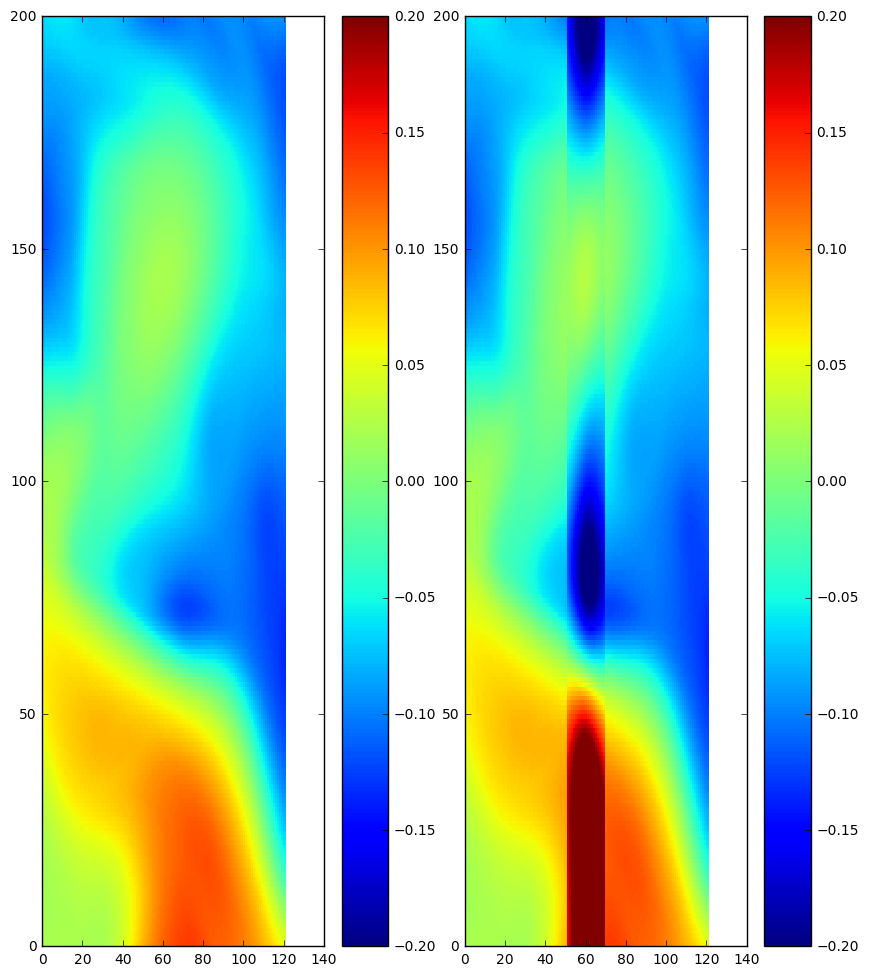

In [19]:
plt.figure(figsize=(10,12))
plt.subplot(121)
plt.pcolor(swot_pass_t7_b.SSH_model.T, vmin=-.2, vmax=.2)
plt.colorbar()
plt.subplot(122)
plt.pcolor(SSH_model_gap_full.T, vmin=-.2, vmax=.2)
plt.colorbar()

/Users/laura/anaconda2/lib/python2.7/site-packages/matplotlib/colors.py:576: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


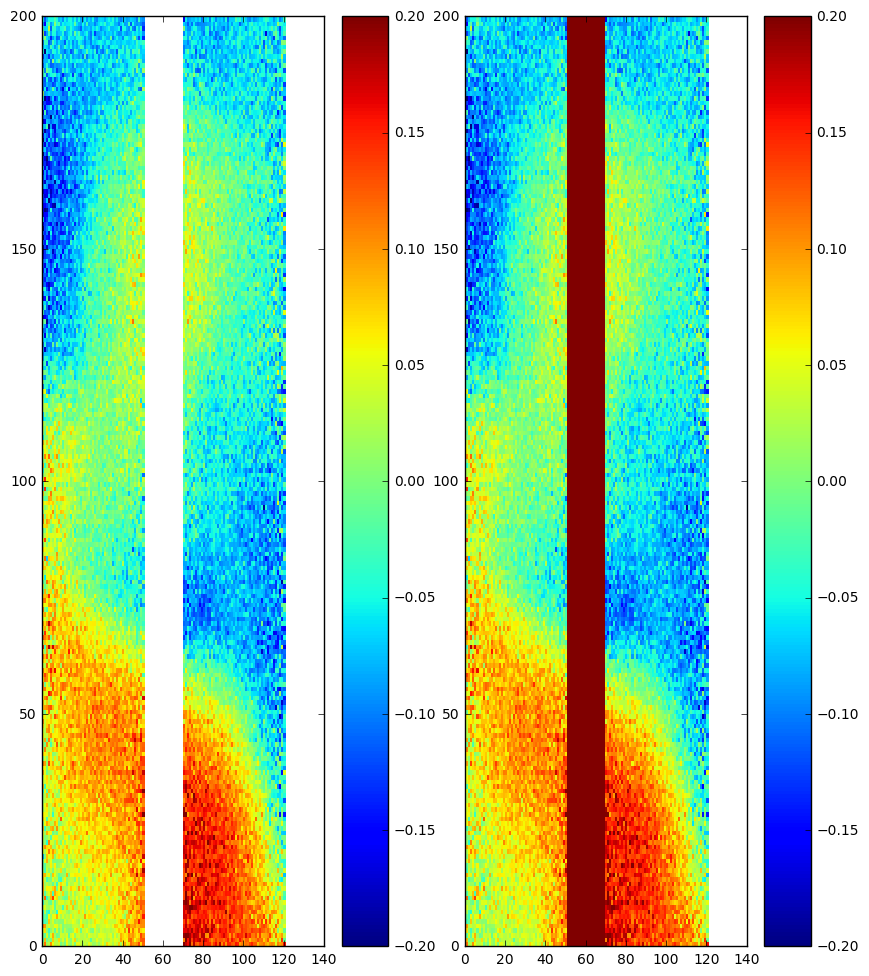

In [20]:
plt.figure(figsize=(10,12))
plt.subplot(121)
plt.pcolor(swot_pass_t7_b.SSH_obs.T, vmin=-.2, vmax=.2)
plt.colorbar()
plt.subplot(122)
plt.pcolor(SSH_obs_gap_full.T, vmin=-.2, vmax=.2)
plt.colorbar()

# --> need to fix the preaprtion of the array before the gaussian filter 
# --> Found solution: look at 2017-11-28_REG_filter_example_NEWODEULEVERSION.ipynb, need to set masked values to 0.

In [22]:
##=================Preparing the SWOT data arrays===============

# 1. Making SWOT array organized as (lon, lat) a.k.a., (x, y): 
## Not sure how to check this: --> for now ok, boxes saves as x, yso no need for this step
"""
lon = np.transpose(lon)
lat = np.transpose(lat)
SSH_model = np.transpose(SSH_model)
SSH_obs = np.transpose(SSH_obs)
"""

# 2. Check longitude in -180 : +180 format:
if any(xlo < 0 for xlo in swot_pass_t7_b.lon):
    swot_pass_t7_b.lon[swot_pass_t7_b.lon > 180] -= 360 

# 3. Flipping the SWOT array if necessary: 
# So that lon increases from left to right and lat from bottom to top 
# (depends on if pass is ascending or descending)

lon_dif = swot_pass_t7_b.lon[1,0] - swot_pass_t7_b.lon[0,0]
lat_dif = swot_pass_t7_b.lat[0,1] - swot_pass_t7_b.lat[0,0]

# Need to revise below , above already adapted for datasets oragnized as x,y instead of y,x
if (lat_dif<0):
    print 'flipped variables created'
    ## Ascending pass (pass 22 for in the fast-sampling phase)        
    lon = np.flipud(swot_pass_t7_b.lon)
    lat = np.flipud(swot_pass_t7_b.lat)
    SSH_model = np.flipud(swot_pass_t7_b.SSH_model)
    SSH_obs = np.flipud(swot_pass_t7_b.SSH_obs)

elif (lon_dif<0):
    print 'flipped variables created'
    ## Descending pass (pass 9 for in the fast-sampling phase)
    lon = np.fliplr(swot_pass_t7_b.lon)
    lat = np.fliplr(swot_pass_t7_b.lat)
    SSH_model = np.fliplr(swot_pass_t7_b.SSH_model)
    SSH_obs = np.fliplr(swot_pass_t7_b.SSH_obs)

    
# 3. Fixing the SWOT grid (regular longitude increments, i.e., no jump in swath gap or repeated nadir values)
# At a 1km resolution, should have a size of 121 across track (size of first dim after transposing)    

xx, yy = swot_pass_t7_b.lon.shape
if (swot_pass_t7_b.lon[(xx/2)-1, 0] == swot_pass_t7_b.lon [xx/2, 0]): # this only happens
# when simulation is done with no gap
    print '_nogap variables created'
    # if no gap simulaton case need to eliminate repeated nadir value
    lon_nogap = np.delete(swot_pass_t7_b.lon, (xx/2), axis=0)
    lat_nogap = np.delete(swot_pass_t7_b.lat, (xx/2), axis=0)
    SSH_model_nogap = np.delete(swot_pass_t7_b.SSH_model, (xx/2), axis=0)
    SSH_obs_nogap = np.delete(swot_pass_t7_b.SSH_obs, (xx/2), axis=0)
    x_ac_nogap = np.delete(swot_pass_t7_b.x_ac, (xx/2), axis=0)
    
"""
check need of this below:
# Obtain full land mask:
SSH_model_nogap = np.ma.masked_invalid(SSH_model_nogap)    
SSH_obs_nogap = np.ma.masked_invalid(SSH_obs_nogap)   
mask_land = SSH_obs_nogap.mask

# Convert gap values to 0:
gap_indices = np.where((x_ac_nogap > -10) & (x_ac_nogap < 10))
SSH_model_nogap[gap_indices[0]] = gap_values
SSH_obs_nogap[gap_indices[0]] = gap_values
"""

# 5. Masking the SWOT outputs
## 5.1. Change masked values to 0:
mask_gap = swot_pass_t7_b.SSH_obs.mask 

swot_pass_t7_b.SSH_model[mask_gap] = 0. 
swot_pass_t7_b.SSH_obs[mask_gap] = 0. 

## 5.2. Converting variables to masked array
SSH_model_ma = np.ma.masked_array(swot_pass_t7_b.SSH_model, mask_gap)
SSH_obs_ma = np.ma.masked_array(swot_pass_t7_b.SSH_obs, mask_gap)

## 5.3. Applying the gaussian filter:

sigma = 10 # --> this sigma?
SSH_model_gausf = gaussian_with_nans(SSH_model_ma, sigma)
SSH_obs_gausf = gaussian_with_nans(SSH_obs_ma, sigma)

## 5.4 Assigning the gaussian filtered data to the gap:

SSH_model_gap_full = SSH_model_ma.copy()
SSH_obs_gap_full = SSH_obs_ma.copy()

SSH_model_gap_full[mask_gap] = SSH_model_gausf[mask_gap]
SSH_obs_gap_full[mask_gap] = SSH_obs_gausf[mask_gap] # or leave it as SSH_obs_nogap.mask? and one variable less?

# No need of this step here for this dataset, will implement this check later:
"""
# 5. Creating the gap values array if necessary:
# The half-swath gap values will be set to 0 and masked.

SWOT_grid_resolution = abs(x_ac[1] - x_ac[0]) # pixel size in km
gap_size = 20. # size of the the half-swath gap in km
gap_pixels = (gap_size / SWOT_grid_resolution) - 1 # -1 so that no repeat nadir value
gap_values = np.ma.zeros((gap_pixels, yy))
gap_values.mask = True
gap_values.fill_value = 0
"""


/Users/laura/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:73: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


'\n# 5. Creating the gap values array if necessary:\n# The half-swath gap values will be set to 0 and masked.\n\nSWOT_grid_resolution = abs(x_ac[1] - x_ac[0]) # pixel size in km\ngap_size = 20. # size of the the half-swath gap in km\ngap_pixels = (gap_size / SWOT_grid_resolution) - 1 # -1 so that no repeat nadir value\ngap_values = np.ma.zeros((gap_pixels, yy))\ngap_values.mask = True\ngap_values.fill_value = 0\n'

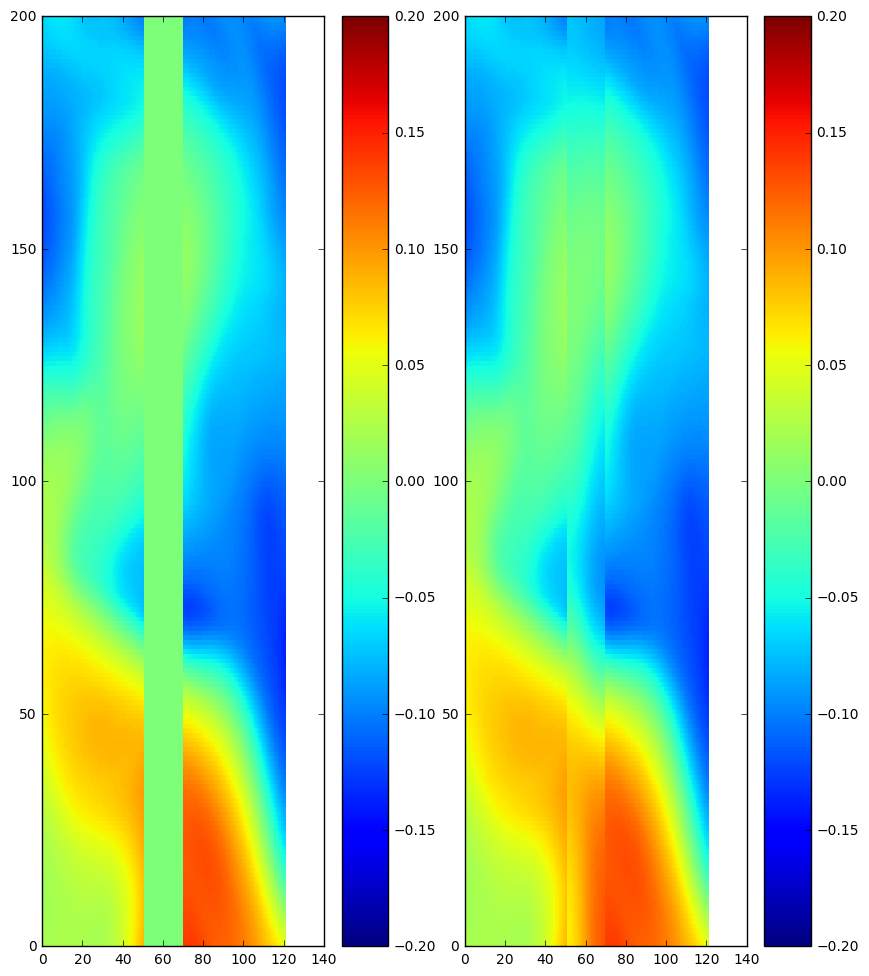

In [23]:
plt.figure(figsize=(10,12))
plt.subplot(121)
plt.pcolor(swot_pass_t7_b.SSH_model.T, vmin=-.2, vmax=.2)
plt.colorbar()
plt.subplot(122)
plt.pcolor(SSH_model_gap_full.T, vmin=-.2, vmax=.2)
plt.colorbar()

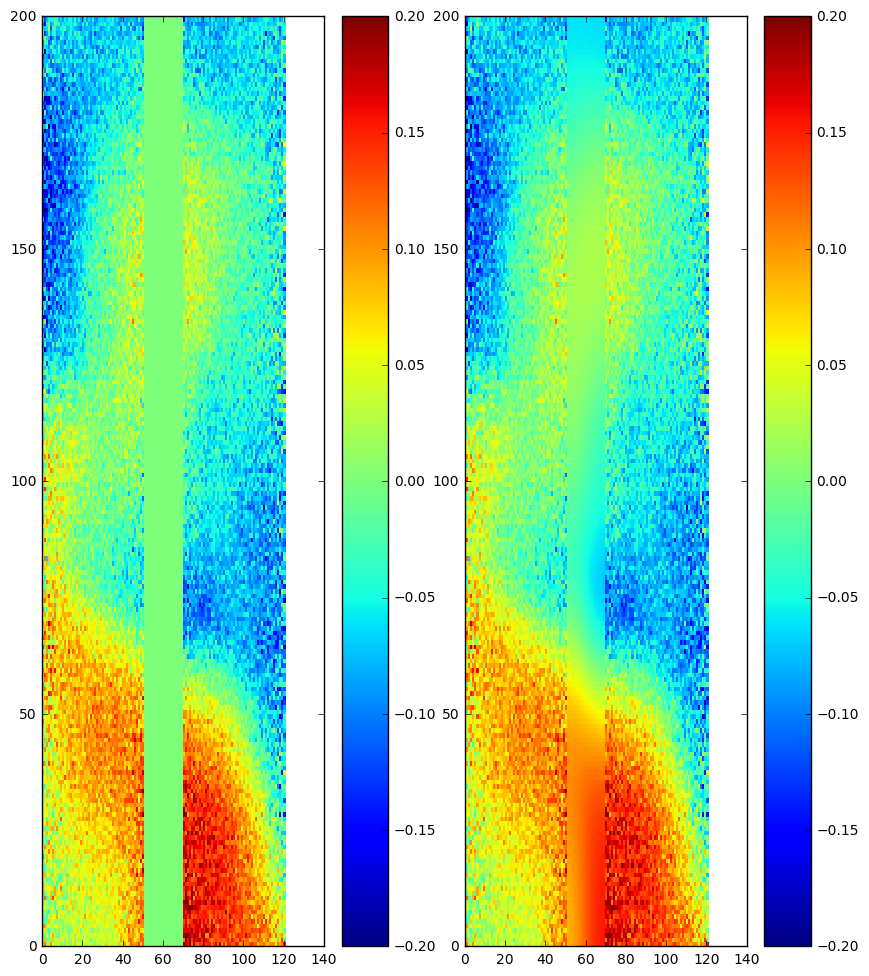

In [24]:
plt.figure(figsize=(10,12))
plt.subplot(121)
plt.pcolor(swot_pass_t7_b.SSH_obs.T, vmin=-.2, vmax=.2)
plt.colorbar()
plt.subplot(122)
plt.pcolor(SSH_obs_gap_full.T, vmin=-.2, vmax=.2)
plt.colorbar()

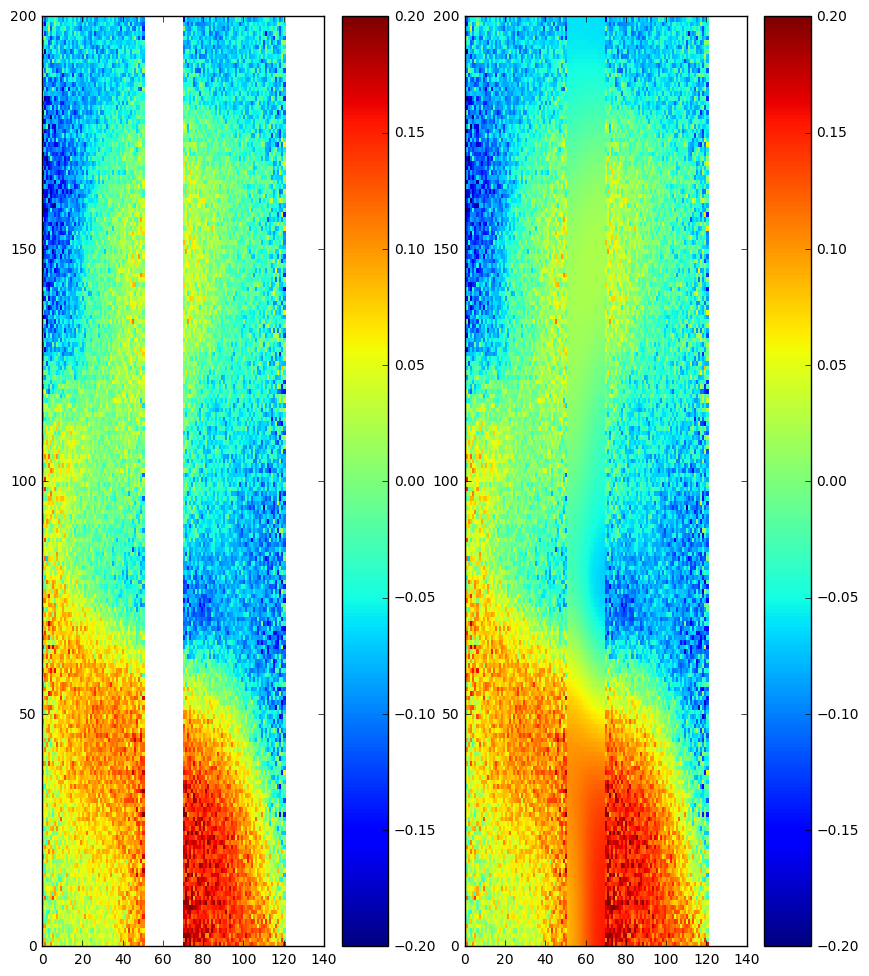

In [25]:
plt.figure(figsize=(10,12))
plt.subplot(121)
plt.pcolor(SSH_obs_ma.T, vmin=-.2, vmax=.2)
plt.colorbar()
plt.subplot(122)
plt.pcolor(SSH_obs_gap_full.T, vmin=-.2, vmax=.2)
plt.colorbar()

# Filtering:

In [33]:
def penalization_filter(var, iter_max, lambd, regularization_model):
    '''
    var = variable to be filtered
    iter_max = maximum number of iterations or 'cc' if convergence criteria is to be applied.  (cc by default)
    lambd = lambda: regularization parameter (the larger lambda, the more regular is the denoised image).  This parameter needs to be adapted to the regularization model. 
    regularization_model = 0 if Tikhonov regularization and 1 if second order penalization (regularization of vorticity)
    '''

    ima = var
    ima_obs = var

    if regularization_model == 0:
        tau = 1./(8*lambd)

        if iter_max == 'cc':
            epsilon = 0.000001
            
            itern = 1
            imaf = ima + tau*(ima_obs - ima + lambd*np_laplacian(ima))

            numerator_norm = np.nansum(gradi(imaf - ima)**2) + np.nansum(gradj(imaf - ima)**2)
            ima_norm = np.nansum(gradi(ima)**2) + np.nansum(gradj(ima)**2)
            conv_crit = numerator_norm / ima_norm
        
            while conv_crit > epsilon:
                ima = np.copy(imaf)
                itern = itern + 1
                print 'iteration: ' + str(itern)
                imaf = ima + tau*(ima_obs - ima + lambd*np_laplacian(ima))
                numerator_norm = np.nansum(gradi(imaf - ima)**2) + np.nansum(gradj(imaf - ima)**2)
                ima_norm = np.nansum(gradi(ima)**2) + np.nansum(gradj(ima)**2)
                conv_crit = numerator_norm / ima_norm

        else:
            
            for k in xrange(0,iter_max):
                ima = ima + tau*(ima_obs - ima + lambd*laplacian(ima))
            imaf = ima

    elif regularization_model == 1:
        
        tau=1./(512*lambd)
        
        if iter_max == 'cc':
            epsilon = 0.000001
            
            itern = 1
            imaf = ima + tau*(ima_obs-ima+lambd*laplacian(laplacian(laplacian(ima))))

            numerator_norm = np.nansum(gradi(imaf - ima)**2) + np.nansum(gradj(imaf - ima)**2)
            ima_norm = np.nansum(gradi(ima)**2) + np.nansum(gradj(ima)**2)
            conv_crit = numerator_norm / ima_norm
        
            while conv_crit > epsilon:
                ima = np.copy(imaf)
                itern = itern + 1
                print 'iteration: ' + str(itern)
                imaf = ima + tau*(ima_obs - ima + lambd*laplacian(laplacian(laplacian(ima))))
                numerator_norm = np.nansum(gradi(imaf - ima)**2) + np.nansum(gradj(imaf - ima)**2)
                ima_norm = np.nansum(gradi(ima)**2) + np.nansum(gradj(ima)**2)
                conv_crit = numerator_norm / ima_norm

        else:

            for k in xrange(0, iter_max):
                ima = ima + tau*(ima_obs-ima+lambd*laplacian(laplacian(laplacian(ima))))
            imaf = ima 

    return imaf


# --> doesn't let me set ='cc' by default

# Example of filter:

In [34]:
filt_SSH_model  = penalization_filter(SSH_model_gap_full, iter_max='cc', lambd=40, regularization_model=0)
filt_SSH_obs    = penalization_filter(SSH_obs_gap_full, iter_max='cc', lambd=40, regularization_model=0)

iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
iteration: 72
iteration: 73


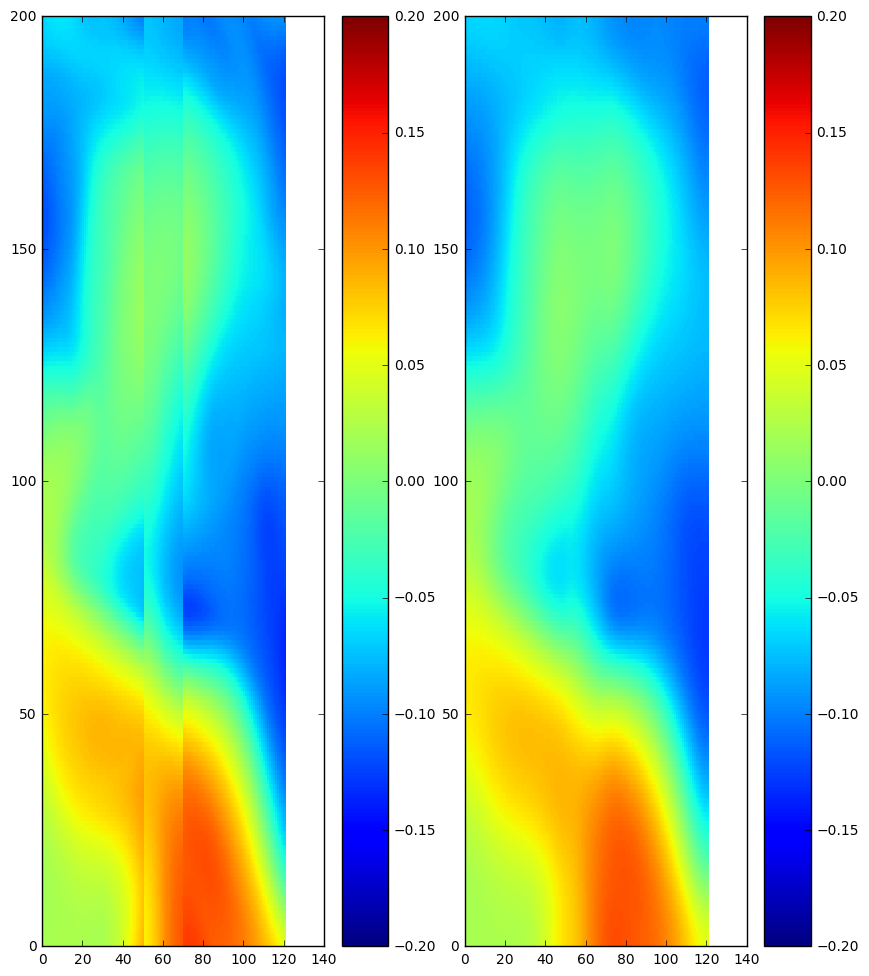

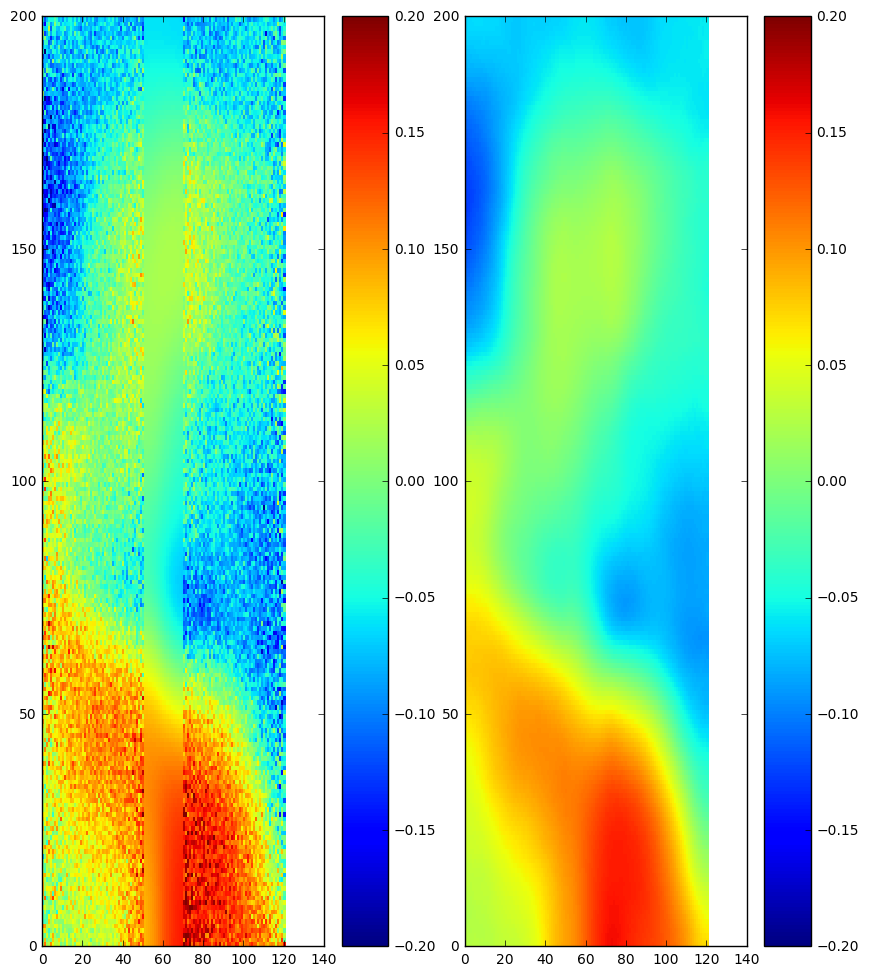

In [35]:
plt.figure(figsize=(10,12))
plt.subplot(121)
plt.pcolor(SSH_model_gap_full.T, vmin=-.2, vmax=.2)
plt.colorbar()
plt.subplot(122)
plt.pcolor(filt_SSH_model.T, vmin=-.2, vmax=.2)
plt.colorbar()

plt.figure(figsize=(10,12))
plt.subplot(121)
plt.pcolor(SSH_obs_gap_full.T, vmin=-.2, vmax=.2)
plt.colorbar()
plt.subplot(122)
plt.pcolor(filt_SSH_obs.T, vmin=-.2, vmax=.2)
plt.colorbar()

# --> in both _obs and _model, can see signal of gap, try to improve, with changing sigma for e.g.

# If fillgap option set to no:

In [36]:
filt_SSH_obs = np.ma.masked_array(filt_SSH_obs, mask_gap)

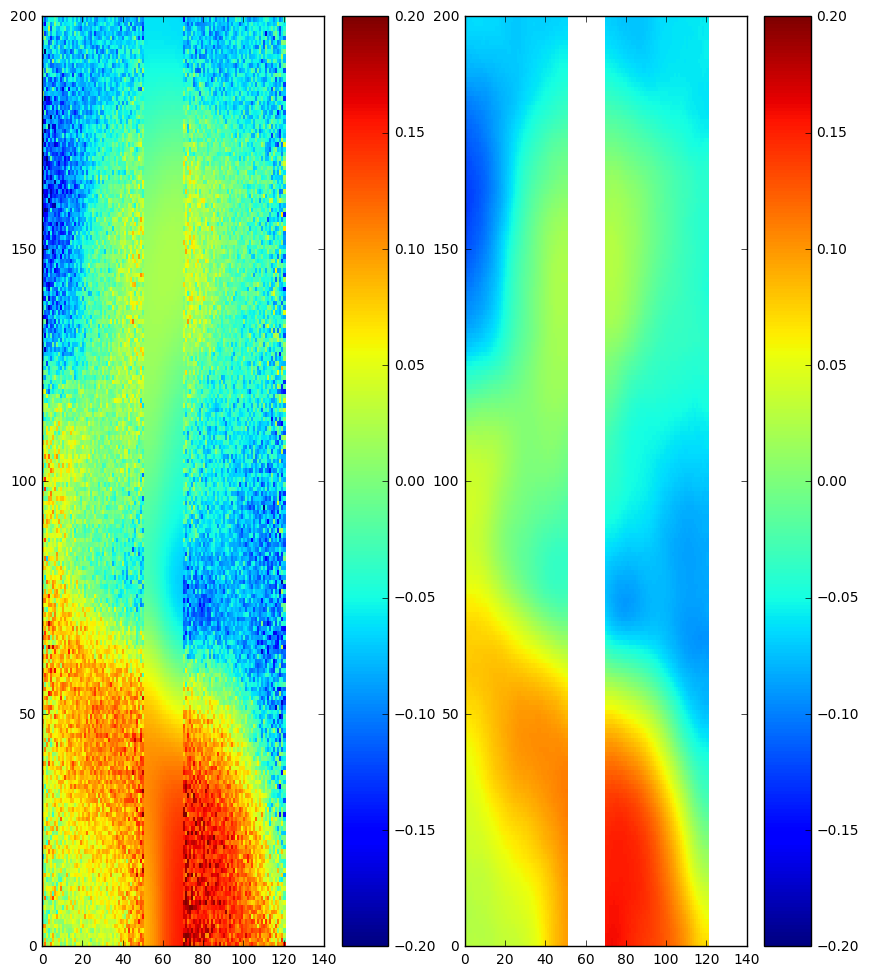

In [37]:
plt.figure(figsize=(10,12))
plt.subplot(121)
plt.pcolor(SSH_obs_gap_full.T, vmin=-.2, vmax=.2)
plt.colorbar()
plt.subplot(122)
plt.pcolor(filt_SSH_obs.T, vmin=-.2, vmax=.2)
plt.colorbar()

# Convergence criteria update:

In [38]:
# A given number or 0 if convergence criteria:
# Maximum number of iterations (could be replaced with a convergence
# criteria on the variable ima: for instance:
# ||ima^{k+1}-ima^k}||/||ima^k||<epsilon)

In [39]:
def penalization_filter(var, iter_max, lambd, regularization_model):
    '''
    var = variable to be filtered
    iter_max = maximum number of iterations or 'cc' if convergence criteria is to be applied.  (cc by default)
    lambd = lambda: regularization parameter (the larger lambda, the more regular is the denoised image).  This parameter needs to be adapted to the regularization model. 
    regularization_model = 0 if Tikhonov regularization and 1 if second order penalization (regularization of vorticity)
    '''

    ima = var
    ima_obs = var

    if regularization_model == 0:
        tau = 1./(8*lambd)

        if iter_max == 'cc':
            epsilon = 0.000001
            
            itern = 1
            imaf = ima + tau*(ima_obs - ima + lambd*np_laplacian(ima))

            conv_crit = np.nansum((imaf - ima)**2) / np.nansum(ima**2)
            
            while conv_crit > epsilon:
                ima = np.copy(imaf)
                itern = itern + 1
                print 'iteration: ' + str(itern)
                imaf = ima + tau*(ima_obs - ima + lambd*np_laplacian(ima))
                conv_crit = np.nansum((imaf - ima)**2) / np.nansum(ima**2)
        else:
            
            for k in xrange(0,iter_max):
                ima = ima + tau*(ima_obs - ima + lambd*laplacian(ima))
            imaf = ima

    elif regularization_model == 1:
        
        tau=1./(512*lambd)
        
        if iter_max == 'cc':
            epsilon = 0.000001
            
            itern = 1
            imaf = ima + tau*(ima_obs-ima+lambd*laplacian(laplacian(laplacian(ima))))

            conv_crit = np.nansum((imaf - ima)**2) / np.nansum(ima**2)
        
            while conv_crit > epsilon:
                ima = np.copy(imaf)
                itern = itern + 1
                print 'iteration: ' + str(itern)
                imaf = ima + tau*(ima_obs - ima + lambd*laplacian(laplacian(laplacian(ima))))
                conv_crit = np.nansum((imaf - ima)**2) / np.nansum(ima**2)
        else:

            for k in xrange(0,iter_max):
                ima = ima + tau*(ima_obs-ima+lambd*laplacian(laplacian(laplacian(ima))))
            imaf = ima 

    return imaf


In [40]:
filt_SSH_model  = penalization_filter(SSH_model_gap_full, iter_max='cc', lambd=40, regularization_model=0)
filt_SSH_obs    = penalization_filter(SSH_obs_gap_full, iter_max='cc', lambd=40, regularization_model=0)

iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31


# --> now iterations stopped at 10 for _model instead of 122 and at 31 instead of 133 for _obs

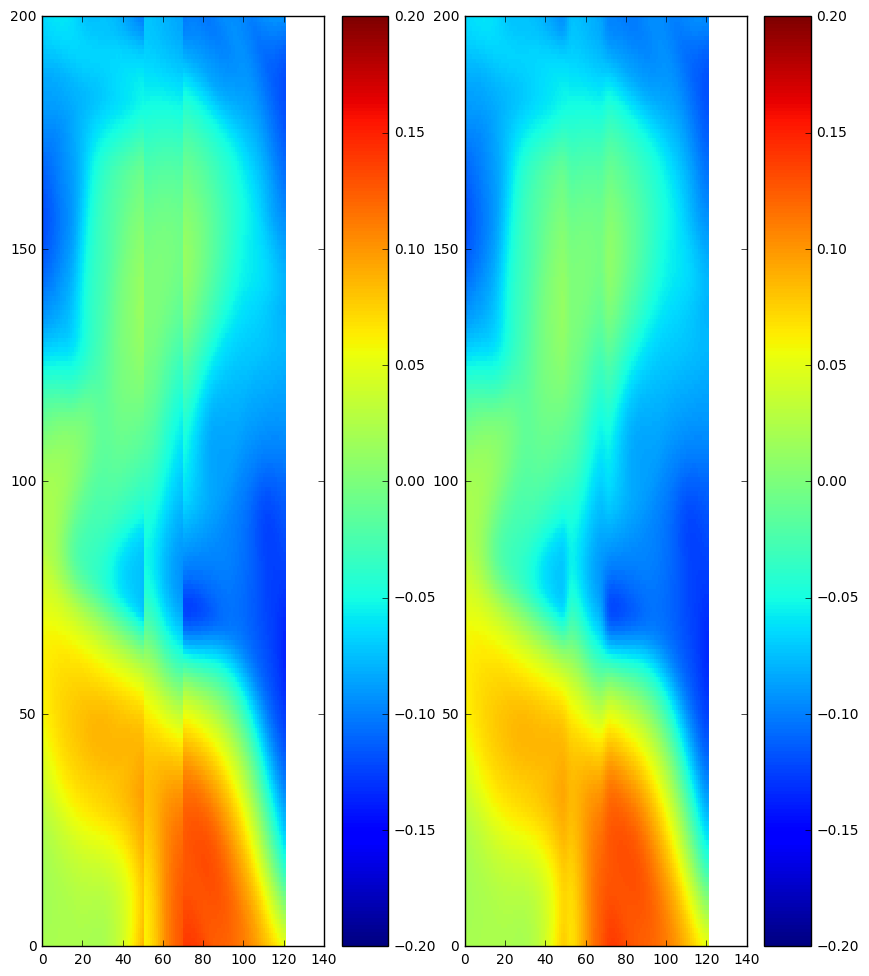

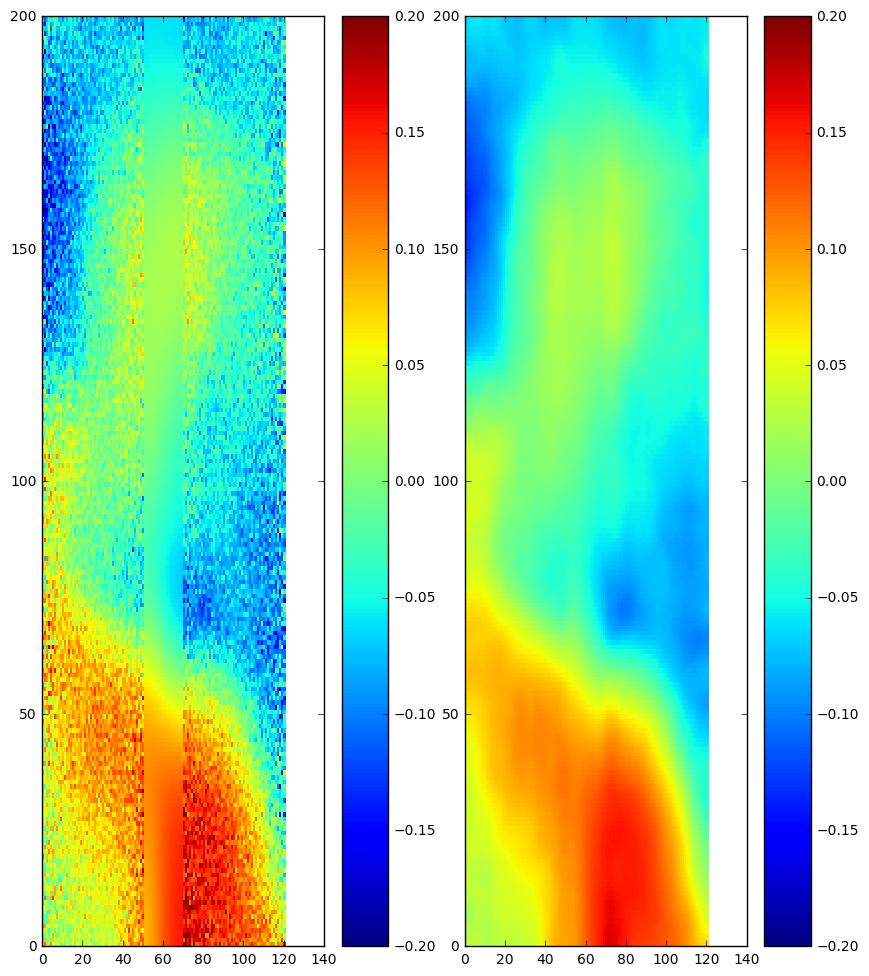

In [41]:
plt.figure(figsize=(10,12))
plt.subplot(121)
plt.pcolor(SSH_model_gap_full.T, vmin=-.2, vmax=.2)
plt.colorbar()
plt.subplot(122)
plt.pcolor(filt_SSH_model.T, vmin=-.2, vmax=.2)
plt.colorbar()

plt.figure(figsize=(10,12))
plt.subplot(121)
plt.pcolor(SSH_obs_gap_full.T, vmin=-.2, vmax=.2)
plt.colorbar()
plt.subplot(122)
plt.pcolor(filt_SSH_obs.T, vmin=-.2, vmax=.2)
plt.colorbar()

# --> sign of gap in filtred image is worse, but if not _obs is well filtered

# With mask:

In [60]:
def penalization_filter_mask(var=SSH_obs_gap_full, mask_of_data=mask_gap, var_obs=SSH_obs_ma, lambd=40
              , regularization_model=1, iter_max=500, epsilon=0.000001):
    '''
    
    -Input(s):
    --var = variable to be filtered
    Default = 
    --mask_of_data = array of True and False values.  0 when land or swath gap values.
    Default = 
    --var_obs = orginal data without filling the masked values 
    --lambd = lambda: regularization parameter (the larger lambda, the more regular is the denoised image).  
    This parameter needs to be adapted to the regularization model. 
    --regularization_model = 0 if Tikhonov regularization (first order penalization, i.e. gradient penalization) 
    and 1 if third order penalization (regularization of vorticity)
    --iter_max = maximum number of iterations in case it takes very long to converge
    --epsilon = 
    -Output(s):
    --ima1 = filtered image
    --itern = number of iterations realized until convergence
    '''
    
    ima_ini = var
    ima_obs = var_obs
    
    mask01 = np.ones_like(var)
    mask01[mask_of_data] = 0
    
    if regularization_model == 0:
        tau = 1./(8*lambd)
        operator = laplacian
    elif regularization_model == 1:
        tau=1./(512*lambd)
        operator = trilaplacian
    else:
        print "Undefined regularization model"
    
    itern = 1
    ima_f = ima_ini + tau*(mask01 * (ima_obs - ima_ini) + lambd*operator(ima_ini))

    conv_crit = np.nansum((ima_f - ima_ini)**2) / np.nansum(ima_ini**2)

    while conv_crit > epsilon:
        ima_ini = np.copy(ima_f)
        itern = itern + 1
        ima_f = ima_ini + tau*(mask01 * (ima_obs - ima_ini) + lambd*operator(ima_ini))
        conv_crit = np.nansum((ima_f - ima_ini)**2) / np.nansum(ima_ini**2)
            
    return ima_f, itern


# -->iter_max not used

In [61]:
filt_SSH_model, iter_m  = penalization_filter_mask(var=SSH_model_gap_full, mask_of_data=mask_gap, var_obs=SSH_model_ma)
filt_SSH_obs, iter_o    = penalization_filter_mask()

In [62]:
print iter_m
print iter_o

1
49


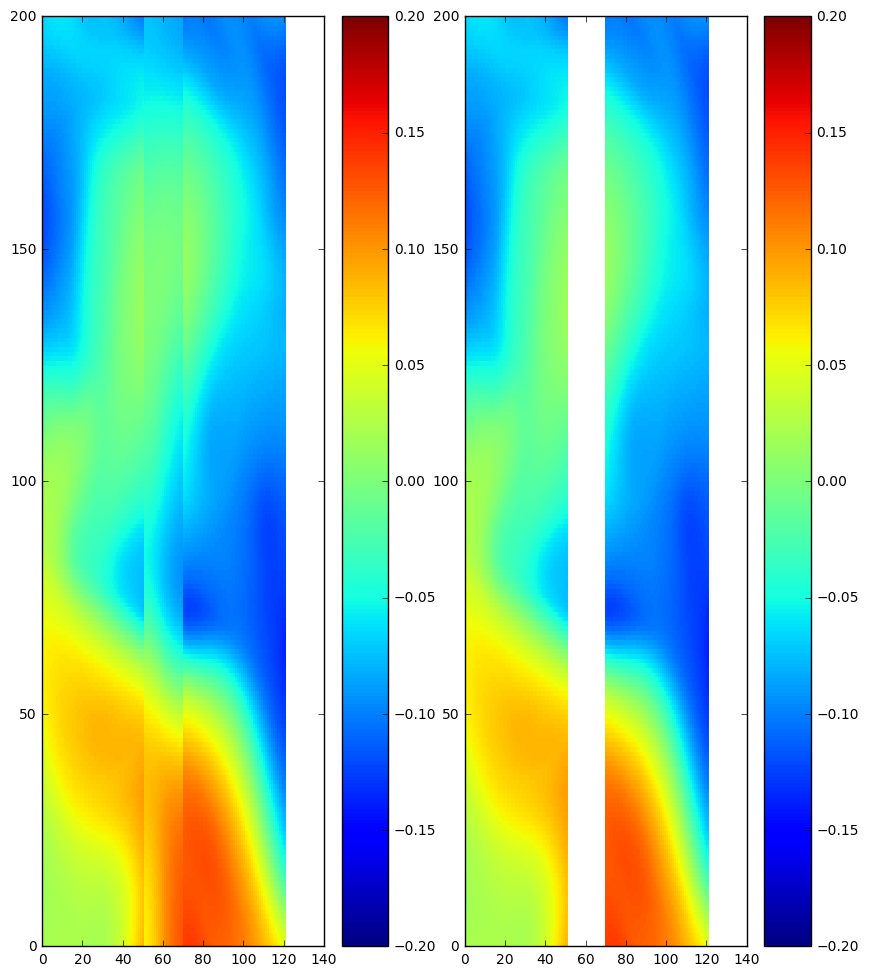

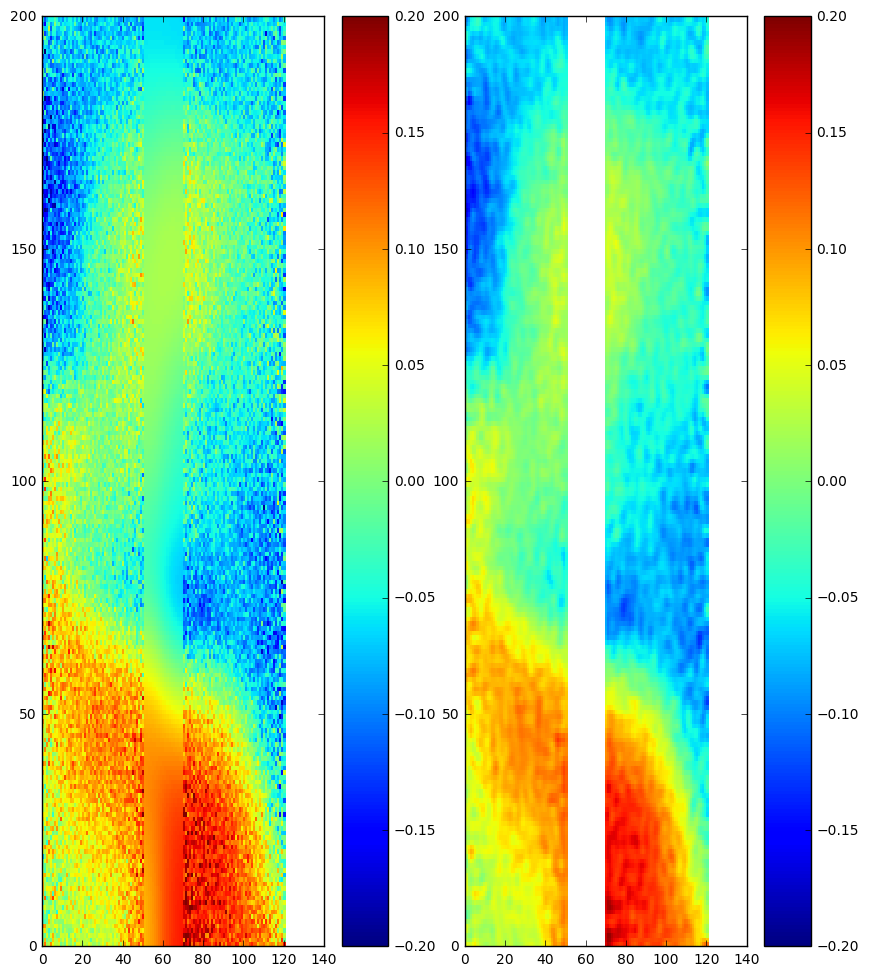

In [63]:
plt.figure(figsize=(10,12))
plt.subplot(121)
plt.pcolor(SSH_model_gap_full.T, vmin=-.2, vmax=.2)
plt.colorbar()
plt.subplot(122)
plt.pcolor(filt_SSH_model.T, vmin=-.2, vmax=.2)
plt.colorbar()

plt.figure(figsize=(10,12))
plt.subplot(121)
plt.pcolor(SSH_obs_gap_full.T, vmin=-.2, vmax=.2)
plt.colorbar()
plt.subplot(122)
plt.pcolor(filt_SSH_obs.T, vmin=-.2, vmax=.2)
plt.colorbar()

In [64]:
filt_SSH_model[mask_gap] = False
filt_SSH_obs[mask_gap] = False

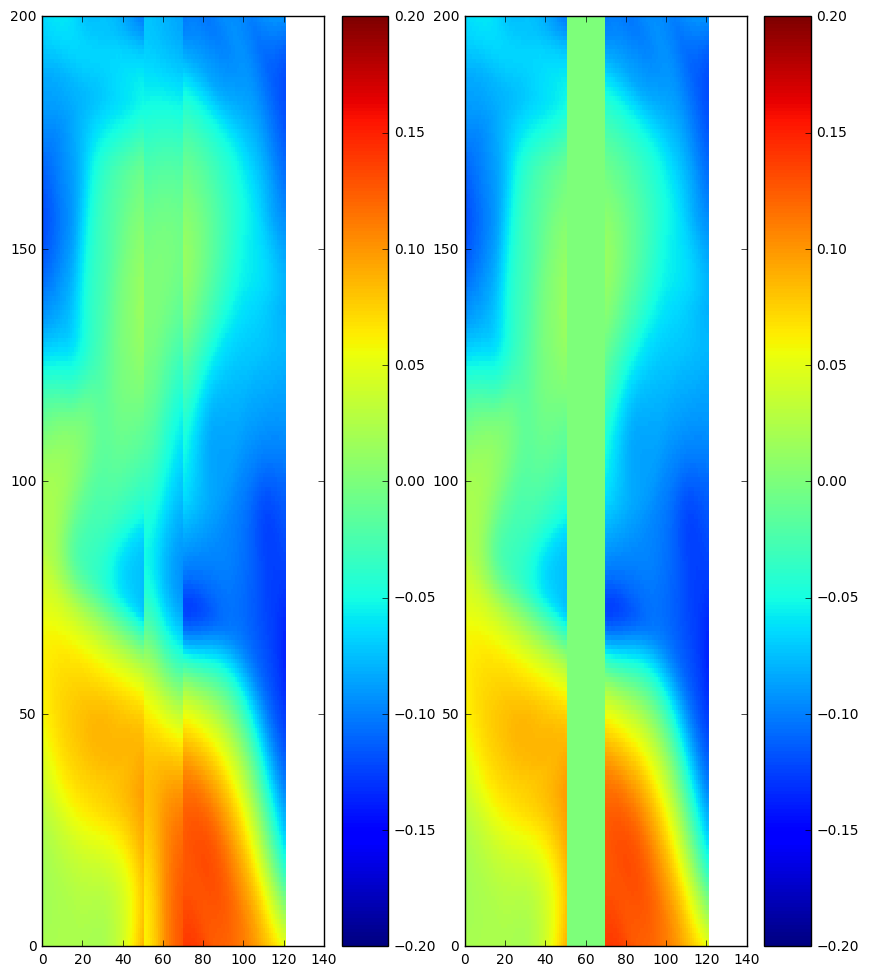

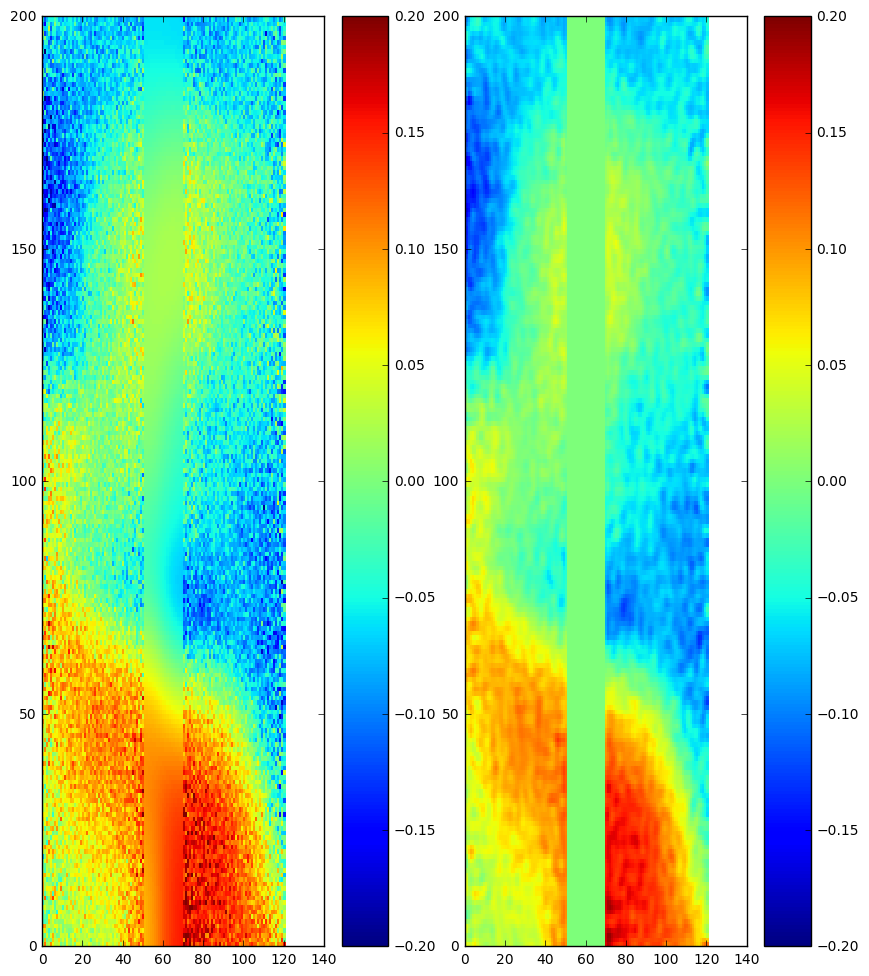

In [65]:
plt.figure(figsize=(10,12))
plt.subplot(121)
plt.pcolor(SSH_model_gap_full.T, vmin=-.2, vmax=.2)
plt.colorbar()
plt.subplot(122)
plt.pcolor(filt_SSH_model.T, vmin=-.2, vmax=.2)
plt.colorbar()

plt.figure(figsize=(10,12))
plt.subplot(121)
plt.pcolor(SSH_obs_gap_full.T, vmin=-.2, vmax=.2)
plt.colorbar()
plt.subplot(122)
plt.pcolor(filt_SSH_obs.T, vmin=-.2, vmax=.2)
plt.colorbar()

# --> so mask in filtering unnecessary when land filled?

# Adapting the penalization_filter to using the convergence criteria like in the penalization_filter_mask function and using ima_obs :

# --> i.e., not using the mask, but then var_obs and var have to be initially the variable with the gap filled, maybe best to give to the masked values the guassian filter results, or simply compare for the convergence criteria the variables with the masked gap??, but it's also important that the gap is correct if we want to fill it...

In [ ]:
def penalization_filter(var, var_obs, iter_max, lambd, regularization_model):
    '''
    var = variable to be filtered
    iter_max = maximum number of iterations or 'cc' if convergence criteria is to be applied.  (cc by default)
    lambd = lambda: regularization parameter (the larger lambda, the more regular is the denoised image).  This parameter needs to be adapted to the regularization model. 
    regularization_model = 0 if Tikhonov regularization and 1 if second order penalization (regularization of vorticity)
    '''

    ima_ini = var
    ima_obs = var_obs

    if regularization_model == 0:
        tau = 1./(8*lambd)

        if iter_max == 'cc':
            epsilon = 0.000001
            
            itern = 1
            imaf = ima + tau*(ima_obs - ima + lambd*np_laplacian(ima))

            conv_crit = np.nansum((ima - imaf)**2) / np.nansum(ima**2)
            
            while conv_crit > epsilon:
                ima = np.copy(imaf)
                itern = itern + 1
                print 'iteration: ' + str(itern)
                imaf = ima + tau*(ima_obs - ima + lambd*np_laplacian(ima))
                conv_crit = np.nansum((imaf - ima)**2) / np.nansum(ima**2)
        else:
            
            for k in xrange(0, iter_max):
                ima = ima + tau*(ima_obs - ima + lambd*laplacian(ima))
            imaf = ima

    elif regularization_model == 1:
        
        tau=1./(512*lambd)
        
        if iter_max == 'cc':
            epsilon = 0.000001
            
            itern = 1
            imaf = ima + tau*(ima_obs-ima+lambd*laplacian(laplacian(laplacian(ima))))

            conv_crit = np.nansum((imaf - ima)**2) / np.nansum(ima**2)
        
            while conv_crit > epsilon:
                ima = np.copy(imaf)
                itern = itern + 1
                print 'iteration: ' + str(itern)
                imaf = ima + tau*(ima_obs - ima + lambd*laplacian(laplacian(laplacian(ima))))
                conv_crit = np.nansum((imaf - ima)**2) / np.nansum(ima**2)
        else:

            for k in xrange(0,iter_max):
                ima = ima + tau*(ima_obs-ima+lambd*laplacian(laplacian(laplacian(ima))))
            imaf = ima 

    return imaf
